# Deep Learning HW01
Gerald Baulig 0780827 2019/11/05
GitHub: https://github.com/bugerry87/fcnn_scratch

---

In this assignment we are asked to implement a neural network from scratch,
including Backpropagation and Storastic Gradient Decent algorithms.
The assigment includes two tasks:

1. Implement a regression network, and
2. implement a classification network.

## 1. Implement a Regression Network

Implement a regression network for the engery efficiency dataset.
I guess this dataset descripes the termal exchange of a building to its environment.
The dataset has 2 Values (t):

- Heating load, and
- Cooling load

And 8 features:

- Relative compactness,
- Surface area,
- Wall area,
- Roof area,
- Overall hight,
- Orientation,
- Glazing area, and
- Glazing area distribution.

We are required to define a feature-vector out of these features and predict the heating load of the buildings, by minimizing the "sum-of-squares" error function,

$$
\begin{equation}
E(w) = \sum_{n=1}^{N}{(t_n - y(X_n;w))^2}
\tag{1}
\end{equation}
$$

...while the evaluation should be processed by the "root-mean-square" error (basically an Euclidean distance :-),

$$
\begin{equation}
E_{RMS}(w) = \frac{\sqrt{\sum_{n=1}^{N}{(t_n - y(x_n;w))^2}}}{\sqrt{N}}
\tag{2}
\end{equation}
$$

## 2. Implement a Classifier

Implement a classification network for the Ionosphere dataset.



# A Fully-Connected Neural Network from Scratch

First, let's define what a Neural Network is.
A Neural Network is a class that can train and validate the weight of a stack of layers, w.r.t several hyper-parameters.
However, all what the Neural Network needs to know about his own network is, where to get its output from. Furthermore, the hyper-parameters are only required in the training process, but only few of them in the validation process,
such that the class defination could look like that:

In [1]:
class NeuralNetwork:
    def __init__(self, train_set, val_set, cost_func, loss_func):
        self.train_set = train_set
        self.val_set = val_set
        self.cost = cost_func
        self.loss = loss_func
        pass
    
    def train(self, output_layer, lr, lr_dec):
        self.lr = lr
        self.lr_dec = lr_dec
        self.training = True
        for Y in output_layer.poll_forward():
            Z = np.squeeze(self.cost.f(self.T, Y))
            dZ = self.cost.d(self.T, Y)
            output_layer.push_backward(dZ, self.lr)
            self.lr -= self.lr * self.lr_dec
            yield Z 
        pass
    
    def val(self, output_layer):
        self.training = False
        for Y in output_layer.poll_forward():
            Z = self.loss.f(self.T, Y)
            yield Z
        pass        
    
    def gen_input(self):
        if self.training:
            for self.X, self.T, self.epoch, self.step in self.train_set():
                yield self.X
        else:
            for self.X, self.T, _, _ in self.val_set():
                yield self.X
        pass

## Activation Functions


### ReLU

In [2]:
import numpy as np
class ReLU:
    f = lambda x: np.maximum(x,0).astype(float)
    d = lambda x: (x > 0).astype(float)

#test
print(ReLU.f(np.array([1,-1,5,-5,0])))
print(ReLU.d(np.array([1,-1,5,-5,0])))

[1. 0. 5. 0. 0.]
[1. 0. 1. 0. 0.]


### Sigmoid

In [3]:
import numpy as np
class Sigmoid:
    f = lambda x: 1 / (1 + np.exp(-x))
    def d(x):
        S = Sigmoid.f(x)
        return S * (1 - S)
    pass

#test
print(Sigmoid.f(np.array([1,-1,5,-5,0])))
print(Sigmoid.d(np.array([1,-1,5,-5,0])))

[0.73105858 0.26894142 0.99330715 0.00669285 0.5       ]
[0.19661193 0.19661193 0.00664806 0.00664806 0.25      ]


### Linear

In [4]:
import numpy as np
class Linear:
    f = lambda x: x
    d = lambda x: np.ones(x.shape)

#test
print(Linear.f(np.array([1,-1,5,-5,0])))
print(Linear.d(np.array([1,-1,5,-5,0])))

[ 1 -1  5 -5  0]
[1. 1. 1. 1. 1.]


## Let's Define a Fully-Connected Layer



In [5]:
class FcLayer:
    def __init__(self,
                 params,
                 act_func,
                 input_func,
                 backprop,
                 clipping=False
                ):
        self.w = params[0]
        self.b = params[1]
        self.act = act_func
        self.input = input_func
        self.backprop = backprop
        self.clipping = clipping
        pass
    
    def poll_forward(self):
        '''Polls the output from the underlying layer. (Feed Forward)'''
        for self.x in self.input():
            self.y = self.act.f(np.dot(self.x, self.w) + self.b)
            yield self.y
    
    def push_backward(self, dZ, lr):
        '''Pushes the loss to the underlying layer. (Back Propagation)'''
        dZ = dZ * self.act.d(self.y)
        dw = np.dot(self.x.T, dZ)
        if self.backprop:
            self.backprop(np.dot(dZ, self.w.T), lr)
        self.w += dw * lr if not self.clipping else np.clip(dw * lr, -1, 1)
        if not self.b is 0:
            self.b += np.sum(dZ, axis=0) * lr
        pass

## Loss Functions


In [6]:
import numpy as np
class SOS:
    f = lambda t,y: np.sum(np.power(t - y, 2))
    d = lambda t,y: (t - y) * 2
    
class RMS:
    f = lambda t,y: np.power(SOS.f(t, y) / t.size, 0.5)
    d = lambda t,y: (SOS.d(t, y) / t.size) * 0.5

#test
print("SOS.f", SOS.f(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))
print("SOS.d", SOS.d(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))
print("RMS.f", RMS.f(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))
print("RMS.d", RMS.d(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))

SOS.f 26
SOS.d [ 0 -2  0 10  0]
RMS.f 2.280350850198276
RMS.d [ 0.  -0.2  0.   1.   0. ]


# Regression for Energy Efficiency

## Load and prepare Energy Efficiency Data

In [7]:
import numpy as np

def unpack_EnergyEfficiency_data():
    raw = np.genfromtxt('EnergyEfficiency_data.csv', skip_header=1, delimiter=',')
    N = raw.shape[0]
    data = np.zeros((N,17))
    data[:,:4] = raw[:,:4]     #comp, surf, wall, roof, 
    data[:,4] = raw[:,4]       #hight
    data[:,5] = raw[:,5] == 2  #ori north
    data[:,6] = raw[:,5] == 3  #ori east
    data[:,7] = raw[:,5] == 4  #ori south
    data[:,8] = raw[:,5] == 5  #ori west
    data[:,9] = raw[:,6]       #area
    data[:,10] = raw[:,7] == 1 #area uniform
    data[:,11] = raw[:,7] == 2 #area north
    data[:,12] = raw[:,7] == 3 #area east
    data[:,13] = raw[:,7] == 4 #area south
    data[:,14] = raw[:,7] == 5 #area west
    data[:,15:] = raw[:,8:]    #heat, cold
    return data, N

#fix the random seed for the reproducibility.
#(another hyper-param)
np.random.seed(15)

def gen_data(data, epochs, batch_size, with_trails=False):
    step = 0
    N = data.shape[0]
    X = np.zeros((batch_size, 15))
    T = np.zeros((batch_size, 1))
    for e in range(epochs):
        for n in range(N):
            i = int(step % batch_size)
            X[i] = data[n,:15]
            T[i] = data[n,-2]
            step += 1
            is_trail = not with_trails and n+batch_size >= N
            if not step % batch_size:
                yield X, T, e+is_trail, step
        if with_trails and step % batch_size:
            yield X[:i], T[:i], e+1, step

def split_data(data, N):
    shuffle = np.arange(N)
    np.random.shuffle(shuffle)
    data = data[shuffle]
    split = int(N*0.7)
    train = data[:split]
    val = data[split:]
    return train, val, shuffle

data, N = unpack_EnergyEfficiency_data()
train, val, shuffle = split_data(data, N)

#test
print(data[:5])

[[  0.98 514.5  294.   110.25   0.     1.     0.     0.     0.     0.
    0.     0.     0.     0.     0.    15.55  21.33]
 [  0.98 514.5  294.   110.25   0.     0.     1.     0.     0.     0.
    0.     0.     0.     0.     0.    15.55  21.33]
 [  0.98 514.5  294.   110.25   0.     0.     0.     1.     0.     0.
    0.     0.     0.     0.     0.    15.55  21.33]
 [  0.98 514.5  294.   110.25   0.     0.     0.     0.     1.     0.
    0.     0.     0.     0.     0.    15.55  21.33]
 [  0.9  563.5  318.5  122.5    0.     1.     0.     0.     0.     0.
    0.     0.     0.     0.     0.    20.84  28.28]]


## Configure the Network

Now let's configure our network.
Thanks to Pythons prototyping feature, we simply add each layer to our NeuralNetwork instance.
For a more photonic initalization of the parameters we define a function `init_params`.
With this function we define how many inputs our layer expects and how many outputs this layer will produce.
The number of inputs must be equivalent to the number of nodes the previous layer has,
while output it the number of nodes the current layer has.

Furthermore, there are a lot of hyper-parameters in the parameter initialization.
Few of them are weight-scaling, the use of bias and the initalization itself.
In default we choose an unscaled natural distributed random generator with bias.

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def init_params(inp, outp, scale=1, bias=True, init_func=np.random.randn):
    weights = init_func(inp, outp)
    while not np.all(weights):
        malicious = weights==0.0
        weights[malicious] = init_func(malicious.shape)
    weights *= scale
    return weights, np.zeros(outp) if bias else 0

def init_network(epochs, batch_size):
    nn = NeuralNetwork(
        lambda: gen_data(train, epochs, batch_size),
        lambda: gen_data(val, 1, 1),
        SOS,
        SOS
    )

    nn.In = FcLayer(init_params(15, 20, scale=2),
                  Sigmoid, #act func
                  nn.gen_input,
                  None,
                  clipping=True
                 )

    nn.Fc1 = FcLayer(init_params(20, 10, scale=2),
                  Sigmoid,
                  nn.In.poll_forward,
                  nn.In.push_backward,
                  clipping=True
                 )

    nn.Fc2 = FcLayer(init_params(10, 10, scale=2),
                  Sigmoid,
                  nn.Fc1.poll_forward,
                  nn.Fc1.push_backward,
                  clipping=True
                 )

    nn.Out = FcLayer(init_params(10, 1, scale=1),
                  Linear,
                  nn.Fc2.poll_forward,
                  nn.Fc2.push_backward,
                  clipping=True
                 )
    
    # let's map the model to a dictionery for easy access
    Model = {
        'In':(nn.In.w, nn.In.b),
        'Fc1':(nn.Fc1.w, nn.Fc1.b),
        'Fc2':(nn.Fc2.w, nn.Fc2.b),
        'Out':(nn.Out.w, nn.Out.b)
    }
    return nn, Model

#test
nn, Model = init_network(1, 1)

### Save and Load

Copy, save and load are important functionalities during the training process.
Each epoch we will test our model against a validation set.
While our model approaches more and more the training set,
the model will reach a point where it start to overfit
and the loss of the validation will rise up again.
Before this happen we want to caputre the best model,
by storing the best result after each epoch.
Fortunatelly, copying, storing and loading are easy to implement with Pickle.

In [37]:
import pickle

def copy(nn, model):
    '''Copies the params of a given NeuralNetwork into a dictionary.
    The dictionary must have the attribute name of the layer as a key.
    E.g.: nn.layer1 --> model['layer1']
    
    Agrs:
        nn: The NeuralNetwork
        model: A dict where the params get stored at
    '''
    for k,v in model.items():
        layer = getattr(nn, k)
        model[k] = (layer.w.copy(), layer.b.copy())
    pass

def save(model, name):
    with open(name, 'wb') as file:
        pickle.dump(Model, file)
    pass

def load(nn, name):
    with open(name, 'rb') as file:
        obj = pickle.load(file)
    for k,v in obj.items():
        if hasattr(nn, k):
            layer = getattr(nn, k)
            layer.w = v[0]
            layer.b = v[1]
    pass

#test
copy(nn, Model)
save(Model, "test.pkl")
load(nn, "test.pkl")

### Training

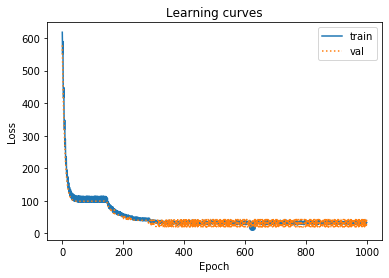

Best Epoch: 622 with a Loss of: 19.716971093512306


In [35]:
#reset the model
nn, Model, Layers = init_network(1000, 100)

def run_training(nn, lr, lr_dec):
    training = []
    validation = []
    epoch = 0
    cost = 0
    best_loss = None
    best_epoch = 0
    
    for Z in nn.train(nn.Out, lr, lr_dec):
        cost += Z / train.shape[0]
        if nn.epoch > epoch:
            loss = 0
            epoch = nn.epoch
            
            for Zv in nn.val(nn.Out):
                loss += Zv / val.shape[0]
                
            if best_loss is None or loss < best_loss:
                best_loss = loss
                best_epoch = epoch
                copy(nn, Model)
                
            validation.append(loss)
            training.append(cost)
            cost = 0
    return training, validation, best_epoch, best_loss

training, validation, best_epoch, best_loss = run_training(nn, 1e-5, 1e-5)
save(Model, "checkpoint.pkl")
ax = plt.figure().subplots(1)
ax.plot(range(nn.epoch), training, label='train')
ax.plot(range(nn.epoch), validation, ':', label='val')
ax.scatter(best_epoch, best_loss)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.title("Learning curves")
plt.legend()
plt.show()
print("Best Epoch:", best_epoch, "with a Loss of:", best_loss)

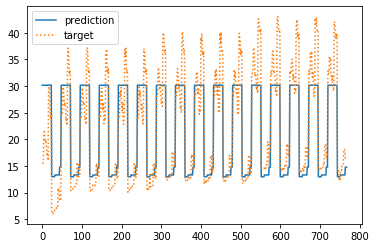

In [36]:
load(Layers, "checkpoint.pkl")

nn.val_set = lambda: gen_data(data, 1, 1)
target = []
pred = []
for Zv in nn.val(nn.Out):
    target.append(nn.T[0][0])
    pred.append(nn.Out.y[0][0])

plt.plot(range(N), pred, label='prediction')
plt.plot(range(N), target, label='target', linestyle=':')

plt.legend()
plt.show()

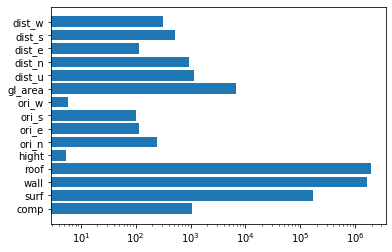

In [49]:
invar = np.var(nn.In.w, axis=1)
y_pos = np.arange(invar.size)
labels = ('comp', 'surf', 'wall', 'roof', 'hight',
          'ori_n', 'ori_e', 'ori_s', 'ori_w',
          'gl_area',
          'dist_u', 'dist_n', 'dist_e', 'dist_s', 'dist_w'
         )
plt.barh(y_pos, invar)
plt.xscale('log')
plt.yticks(y_pos, labels)
plt.show()